In [2]:
import argparse
import os

import cv2
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms

from src.dataset_norms import dataset_norms
from src.models import VisionTransformer, ResNetV2
from src.visualization_functions import generate_sim_maps, show_cam_on_image, norm


In [78]:
# parser = argparse.ArgumentParser(description='Paired Image Visualization')
# parser.add_argument('--dataset', type=str, default='Hotels-50k', help='Choices: Hotels-50k, SOP, GLM')
# parser.add_argument('--imageA', type=str, default='img1.png')
# parser.add_argument('--imageB', type=str, default='img2.png')
# parser.add_argument('--model_type', type=str, default='ViT-B16', help='"ViT-B{patch_size}" or "resnet-101"')
# parser.add_argument('--device', type=str, default='gpu', help='use "GPU" or "CPU"')

# args = parser.parse_args()

imageA_path = os.path.join('images', 'GLM', '7.png')
imageB_path = os.path.join('images', 'GLM', '7_2.png')
model_weights = os.path.join('weights', 'GLM', 'ViT-B16.pth')
save_dir = os.path.join('results', 'GLM', 'ViT-B16.pth')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if 'vit' in 'ViT-B16.pth'.lower():
    patch_size = int('ViT-B16'[-2:]) # Extract patch_size from model weights file
    config = {'output_size': 512, 'init_head': True, 'classifier': 'token', 'hidden_size': 768, 'img_size': 256,
                'patch_size': (patch_size, patch_size), 'load_from': None, 'dropout_rate': 0, 'vis': True,
                'num_layers': 12, 'mlp_dim': 3072, 'num_heads': 12, 'global_feature_embedding': 'mean',
                'attention_dropout_rate': 0}
    model = VisionTransformer(config=config)
elif 'ViT-B16.pth' == 'resnet-101':
    config = {'arch': 'r101', 'width_factor': 1, 'output_size': 512, 'zero_head': False, 'weights_file': None}
    model = ResNetV2(config=config)
else:
    raise ValueError(f"Invalid model_type argument: 'ViT-B16.pth' "
                        "model_type argument must be either ViT-B/{32|16} or resnet-101")

if 'cpu' == 'gpu':
    use_gpu = True
    model.cuda()
else:
    use_gpu = False

weights = torch.load(model_weights, map_location=torch.device('cpu'))
weights = {k.replace('module.', ''): weights[k] for k in weights.keys()}
model.load_state_dict(weights)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(dataset_norms['GLM']['mean'], dataset_norms['GLM']['std'])
])

transform_greyscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3)
])

In [79]:
simmapA, simmapB, sim_score = generate_sim_maps(imageA_path, imageB_path, model, transform, use_gpu=use_gpu)
imageA_gs = transform_greyscale(Image.open(imageA_path).convert("RGB"))
imageA_gs = np.moveaxis(imageA_gs.numpy(), 0, 2)

imageB_gs = transform_greyscale(Image.open(imageB_path).convert("RGB"))
imageB_gs = np.moveaxis(imageB_gs.numpy(), 0, 2)

simmapA = norm(cv2.resize(simmapA, (256, 256), interpolation=cv2.INTER_CUBIC))
simmapA = show_cam_on_image(imageA_gs, simmapA, use_rgb=True)
simmapA = cv2.bitwise_not(simmapA)

simmapB = norm(cv2.resize(simmapB, (256, 256), interpolation=cv2.INTER_CUBIC))
simmapB = show_cam_on_image(imageB_gs, simmapB, use_rgb=True)
simmapB = cv2.bitwise_not(simmapB)

simmapA = Image.fromarray(simmapA)
simmapB = Image.fromarray(simmapB)

imageA_name = os.path.split(imageA_path)[1].split('.')[0]
imageB_name = os.path.split(imageB_path)[1].split('.')[0]

simmapA.save(f'{save_dir}/{imageA_name}_simmap_with_{imageB_name}.png')
simmapB.save(f'{save_dir}/{imageB_name}_simmap_with_{imageA_name}.png')

Diff:  0.662965459510421


In [80]:
import matplotlib.pyplot as plt

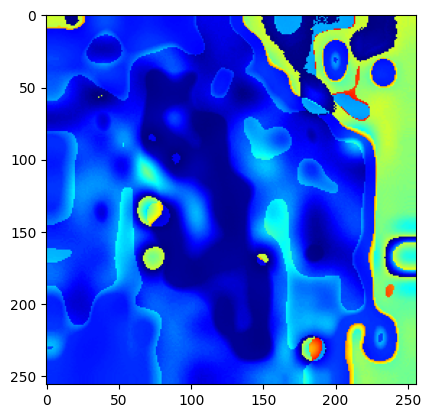

In [81]:
diff_map = (np.array(simmapB) - np.array(simmapA))
diff_map = cv2.bitwise_not(diff_map)
diff_rgb = cv2.applyColorMap(diff_map.astype(np.uint8) , cv2.COLORMAP_JET)


# # # Guardar y visualizar
diff_img = Image.fromarray(diff_rgb)
# diff_img.save(f'{save_dir}/{imageA_name}_diffmap_with_{imageB_name}.png')
plt.imshow(diff_img)

In [27]:
np.array(diff_map, dtype=np.float16).shape[0]

256

In [28]:
diff_map[1][1][1]

71.0

In [31]:
# diff_map = np.array(diff_map, dtype=np.float16)
for i in range(diff_map.shape[0]):
    for j in range(diff_map.shape[1]):
        for k in range(diff_map.shape[2]):
            if diff_map[i][j][k] < 0:
                print('0', diff_map[i][j][k], i, j, k)
            elif diff_map[i][j][k] > 256:
                print('1', diff_map[i][j][k], i, j, k)

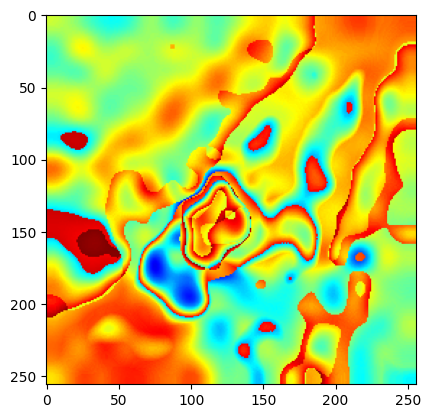

In [ ]:
diff_map = np.array(simmapA) - np.array(simmapB)

diff_rgb = cv2.applyColorMap(diff_map.astype(np.uint8) , cv2.COLORMAP_JET)


# # # Guardar y visualizar
diff_img = Image.fromarray(diff_rgb)
# diff_img.save(f'{save_dir}/{imageA_name}_diffmap_with_{imageB_name}.png')
plt.imshow(diff_img)
    